In [15]:
# === LOAD DATASET
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://raw.githubusercontent.com/fancesatria/heartastic/main/dataset/Cardiovascular_Disease_Dataset.csv")

# **A. DATA PREPROCESSING**

In [16]:
# DROP UNNECESSARY COL AND RENAME COL
df = df.drop(columns=['patientid'], errors='ignore')

df = df.rename(columns={
    'age': 'Age',
    'gender': 'Sex',
    'chestpain': 'ChestPain',
    'restingBP': 'RestBP',
    'serumcholestrol': 'Cholesterol',
    'fastingbloodsugar': 'FastingBS',
    'restingrelectro': 'RestECG',
    'maxheartrate': 'MaxHR',
    'exerciseangia': 'ExerciseAngina',
    'oldpeak': 'Oldpeak',
    'slope': 'ST_Slope',
    'noofmajorvessels': 'NumVessels',
    'target': 'HeartDisease'
})

# DROP COLUMN
df = df.drop(columns=['RestECG', 'MaxHR', 'Oldpeak', 'NumVessels', 'ST_Slope'])

print(df.head())

   Age  Sex  ChestPain  RestBP  Cholesterol  FastingBS  ExerciseAngina  \
0   53    1          2     171            0          0               0   
1   40    1          0      94          229          0               0   
2   49    1          2     133          142          0               1   
3   43    1          0     138          295          1               0   
4   31    1          1     199            0          0               0   

   HeartDisease  
0             1  
1             0  
2             0  
3             1  
4             1  


HeartDisease
1    58.0
0    42.0
Name: proportion, dtype: float64


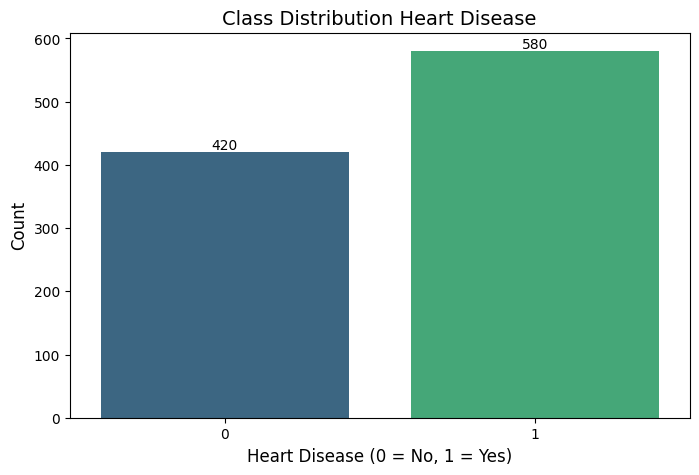

In [17]:
# DATA DISTRIBUTION CHECK
print(df['HeartDisease'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='HeartDisease', hue='HeartDisease', palette='viridis', legend=False)
plt.title("Class Distribution Heart Disease", fontsize=14)
plt.xlabel("Heart Disease (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [18]:
# CLEAN OUTLIER
from scipy.stats import mstats

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("HeartDisease")  # Exclude target

def winsorize_data(data, cols, limits=(0.05, 0.05)):
    data_copy = data.copy()
    for col in cols:
        data_copy[col] = mstats.winsorize(data_copy[col], limits=limits)
    return data_copy

df_winsorized = winsorize_data(df, numeric_cols)
print("Data size (before):", len(df))
print("Data size (after):", len(df_winsorized))

Data size (before): 1000
Data size (after): 1000


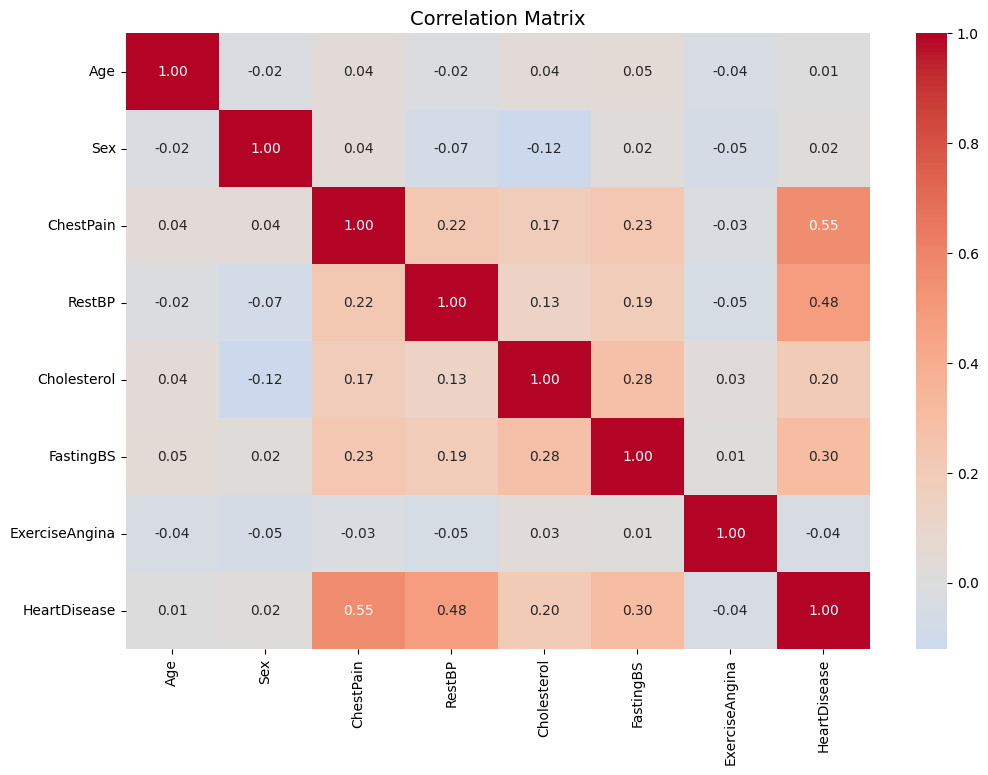

In [19]:
# CORRELATION
# Encode categorical features
le = LabelEncoder()
categorical_cols = df_winsorized.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df_winsorized[col] = le.fit_transform(df[col].astype(str))

# Calculate correlation
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix", fontsize=14)
plt.show()


In [20]:
# FINAL DATA
X = df.drop(columns=["HeartDisease"])
y = df_winsorized["HeartDisease"]

print("\n=== FINAL DATA ===")
print(f"Shape: {df_winsorized.shape}")
print(f"Feature Count: {len(X.columns)}")
print(f"Class Percentage:\n{y.value_counts(normalize=True)*100}")


=== FINAL DATA ===
Shape: (1000, 8)
Feature Count: 7
Class Percentage:
HeartDisease
1    58.0
0    42.0
Name: proportion, dtype: float64


# **B. SPLIT DATA**

In [21]:
# Split 70% for train
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split 30% remains, 30% * 0.33 = 9.9% => 10% for testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
)

# Proportion check
print(f'Train: {len(X_train)} samples')
print(f'Validation: {len(X_val)} samples')
print(f'test: {len(X_test)} samples')

from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Distribution after SMOTE:")
print(pd.Series(y_train_sm).value_counts())

Train: 700 samples
Validation: 201 samples
test: 99 samples
Distribution after SMOTE:
HeartDisease
1    406
0    406
Name: count, dtype: int64


# **C. TRAIN MODEL**

In [22]:
# Evaluation function
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def evaluate_model(name, model, X_train, X_val, X_test, y_train, y_val, y_test):
    print(f"\n=== Evaluation {name} ===")

    y_train_pred = model.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    y_val_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    y_test_pred = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

    print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

def plot_model(name, model):
  train_sizes, train_scores, val_scores = learning_curve(
      model, X_train, y_train, cv=5,
      train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
  )

  plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training')
  plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
  plt.title(f"Learning Curve - {name}")
  plt.xlabel('Training Size')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

# **1. Random Forest**


=== Evaluation Random Forest Before Tuning ===
Train Accuracy: 0.937192118226601
Validation Accuracy: 0.9402985074626866
Test Accuracy: 0.8383838383838383

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.82      0.79      0.80        42
           1       0.85      0.88      0.86        57

    accuracy                           0.84        99
   macro avg       0.84      0.83      0.83        99
weighted avg       0.84      0.84      0.84        99

Confusion Matrix:
 [[33  9]
 [ 7 50]]


RandomForestClassifier(n_estimators=300, oob_score=True, random_state=42)

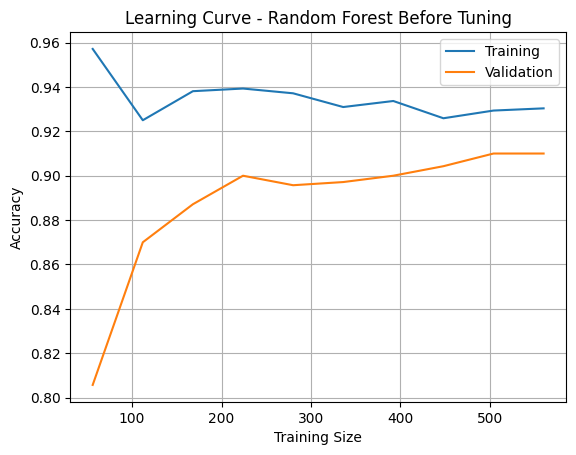

In [23]:
# Training data
# Prevent overfitting
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5, # 5 3
    min_samples_split=10, # 10 15
    min_samples_leaf=5, # 5 10
    max_features='sqrt', # 'sqrt' 0.5
    random_state=42
)

rf_model.fit(X_train_sm, y_train_sm)

# EVALUATION 1
evaluate_model("Random Forest Before Tuning", rf_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)

# EVALUATION 2
plot_model("Random Forest Before Tuning", rf_model)

rf = RandomForestClassifier(oob_score=True, n_estimators=300, random_state=42)
rf.fit(X_train, y_train)


# **DATA TUNING: RANDOM FOREST**

In [24]:
pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.1 MB 2.2 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.1 MB 1.8 MB/s eta 0:00:01
   ------------------------ --------------- 1.3/2.1 MB 1.8 MB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.1 MB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 1.8 MB/s eta 0:00:00

   ---------------------------------------- 0/9 [tqdm]
   ---------------------------------------- 0/9 [tqdm]
   ---------------------------------------- 0/9 [tqdm]
   ---------------------------------------- 0/9 [tqdm]
   -------- ------------------------------- 2/9 [PyYAML]
   -------- ------------------------------- 2/9 [PyYAML]
   -------- ------------------------------- 2/9 [PyYAML]
   ------------- -------------------------- 3/9 [Mako]
   ------------- ------------------

In [25]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Objective Function Optuna
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'random_state': 42,
        'oob_score': True,
        'bootstrap': True
    }

    model = RandomForestClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    return cross_val_score(model, X_train_sm, y_train_sm, cv=cv, scoring='accuracy', n_jobs=-1).mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print("Best Parameters (Random Forest - Optuna):", study_rf.best_trial.params)
print("Best CV Score:", study_rf.best_value)


c:\Users\fance\.conda\envs\heartastic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-04 18:03:04,069] A new study created in memory with name: no-name-03a6f2a2-e6c8-4ebb-8864-1d7dc55b2d69
Best trial: 0. Best value: 0.908892:   3%|▎         | 1/30 [00:14<07:07, 14.75s/it]

[I 2025-08-04 18:03:18,822] Trial 0 finished with value: 0.9088919185033703 and parameters: {'n_estimators': 281, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.3}. Best is trial 0 with value: 0.9088919185033703.


Best trial: 0. Best value: 0.908892:   7%|▋         | 2/30 [00:16<03:20,  7.15s/it]

[I 2025-08-04 18:03:20,653] Trial 1 finished with value: 0.9064379307733091 and parameters: {'n_estimators': 164, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.9088919185033703.


Best trial: 2. Best value: 0.923692:  10%|█         | 3/30 [00:18<02:03,  4.58s/it]

[I 2025-08-04 18:03:22,182] Trial 2 finished with value: 0.9236915852457775 and parameters: {'n_estimators': 123, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 0.5}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  13%|█▎        | 4/30 [00:18<01:16,  2.95s/it]

[I 2025-08-04 18:03:22,620] Trial 3 finished with value: 0.9101113383321973 and parameters: {'n_estimators': 248, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  17%|█▋        | 5/30 [00:18<00:49,  1.98s/it]

[I 2025-08-04 18:03:22,887] Trial 4 finished with value: 0.9076649246383397 and parameters: {'n_estimators': 145, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.3}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  20%|██        | 6/30 [00:19<00:33,  1.38s/it]

[I 2025-08-04 18:03:23,091] Trial 5 finished with value: 0.9113534802696357 and parameters: {'n_estimators': 105, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  23%|██▎       | 7/30 [00:19<00:24,  1.08s/it]

[I 2025-08-04 18:03:23,563] Trial 6 finished with value: 0.9101264864046051 and parameters: {'n_estimators': 285, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  27%|██▋       | 8/30 [00:19<00:19,  1.13it/s]

[I 2025-08-04 18:03:24,032] Trial 7 finished with value: 0.9125956222070741 and parameters: {'n_estimators': 262, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  30%|███       | 9/30 [00:20<00:15,  1.34it/s]

[I 2025-08-04 18:03:24,468] Trial 8 finished with value: 0.9088919185033705 and parameters: {'n_estimators': 259, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  33%|███▎      | 10/30 [00:20<00:13,  1.46it/s]

[I 2025-08-04 18:03:25,011] Trial 9 finished with value: 0.9187533136408392 and parameters: {'n_estimators': 299, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 2. Best value: 0.923692:  37%|███▋      | 11/30 [00:21<00:11,  1.72it/s]

[I 2025-08-04 18:03:25,365] Trial 10 finished with value: 0.8965765356358404 and parameters: {'n_estimators': 207, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 0.5}. Best is trial 2 with value: 0.9236915852457775.


Best trial: 11. Best value: 0.926146:  40%|████      | 12/30 [00:21<00:09,  1.89it/s]

[I 2025-08-04 18:03:25,771] Trial 11 finished with value: 0.9261455729758389 and parameters: {'n_estimators': 216, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 11 with value: 0.9261455729758389.


Best trial: 12. Best value: 0.92738:  43%|████▎     | 13/30 [00:22<00:08,  2.06it/s] 

[I 2025-08-04 18:03:26,159] Trial 12 finished with value: 0.9273801408770733 and parameters: {'n_estimators': 212, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 12 with value: 0.9273801408770733.


Best trial: 13. Best value: 0.933545:  47%|████▋     | 14/30 [00:22<00:07,  2.17it/s]

[I 2025-08-04 18:03:26,563] Trial 13 finished with value: 0.9335454063470424 and parameters: {'n_estimators': 207, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  50%|█████     | 15/30 [00:22<00:06,  2.38it/s]

[I 2025-08-04 18:03:26,886] Trial 14 finished with value: 0.9224570173445429 and parameters: {'n_estimators': 174, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  53%|█████▎    | 16/30 [00:23<00:05,  2.38it/s]

[I 2025-08-04 18:03:27,310] Trial 15 finished with value: 0.9298417026433388 and parameters: {'n_estimators': 230, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 0.5}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  57%|█████▋    | 17/30 [00:23<00:05,  2.35it/s]

[I 2025-08-04 18:03:27,750] Trial 16 finished with value: 0.9323108384458078 and parameters: {'n_estimators': 232, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  60%|██████    | 18/30 [00:23<00:04,  2.53it/s]

[I 2025-08-04 18:03:28,075] Trial 17 finished with value: 0.9162766038021661 and parameters: {'n_estimators': 182, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  63%|██████▎   | 19/30 [00:24<00:04,  2.51it/s]

[I 2025-08-04 18:03:28,481] Trial 18 finished with value: 0.9323108384458078 and parameters: {'n_estimators': 230, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  67%|██████▋   | 20/30 [00:24<00:03,  2.65it/s]

[I 2025-08-04 18:03:28,810] Trial 19 finished with value: 0.9089070665757781 and parameters: {'n_estimators': 188, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  70%|███████   | 21/30 [00:25<00:03,  2.83it/s]

[I 2025-08-04 18:03:29,105] Trial 20 finished with value: 0.9310384003635537 and parameters: {'n_estimators': 149, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  73%|███████▎  | 22/30 [00:25<00:02,  2.71it/s]

[I 2025-08-04 18:03:29,510] Trial 21 finished with value: 0.9310686965083693 and parameters: {'n_estimators': 235, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  77%|███████▋  | 23/30 [00:25<00:02,  2.65it/s]

[I 2025-08-04 18:03:29,909] Trial 22 finished with value: 0.9310838445807772 and parameters: {'n_estimators': 232, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  80%|████████  | 24/30 [00:26<00:02,  2.66it/s]

[I 2025-08-04 18:03:30,279] Trial 23 finished with value: 0.9249185791108081 and parameters: {'n_estimators': 194, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  83%|████████▎ | 25/30 [00:26<00:01,  2.55it/s]

[I 2025-08-04 18:03:30,711] Trial 24 finished with value: 0.9273877149132774 and parameters: {'n_estimators': 223, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  87%|████████▋ | 26/30 [00:27<00:01,  2.36it/s]

[I 2025-08-04 18:03:31,211] Trial 25 finished with value: 0.9249034310384003 and parameters: {'n_estimators': 248, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  90%|█████████ | 27/30 [00:27<00:01,  2.39it/s]

[I 2025-08-04 18:03:31,614] Trial 26 finished with value: 0.9224570173445429 and parameters: {'n_estimators': 199, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  93%|█████████▎| 28/30 [00:28<00:00,  2.26it/s]

[I 2025-08-04 18:03:32,113] Trial 27 finished with value: 0.9298417026433385 and parameters: {'n_estimators': 251, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545:  97%|█████████▋| 29/30 [00:28<00:00,  2.14it/s]

[I 2025-08-04 18:03:32,640] Trial 28 finished with value: 0.9298417026433385 and parameters: {'n_estimators': 268, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 13 with value: 0.9335454063470424.


Best trial: 13. Best value: 0.933545: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]

[I 2025-08-04 18:03:33,171] Trial 29 finished with value: 0.9285995607059 and parameters: {'n_estimators': 277, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 13 with value: 0.9335454063470424.
Best Parameters (Random Forest - Optuna): {'n_estimators': 207, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 0.5}
Best CV Score: 0.9335454063470424



=== Evaluation Random Forest After Optuna Tuning ===
Train Accuracy: 0.9667487684729064
Validation Accuracy: 0.9402985074626866
Test Accuracy: 0.8686868686868687

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.81      0.84        42
           1       0.87      0.91      0.89        57

    accuracy                           0.87        99
   macro avg       0.87      0.86      0.86        99
weighted avg       0.87      0.87      0.87        99

Confusion Matrix:
 [[34  8]
 [ 5 52]]


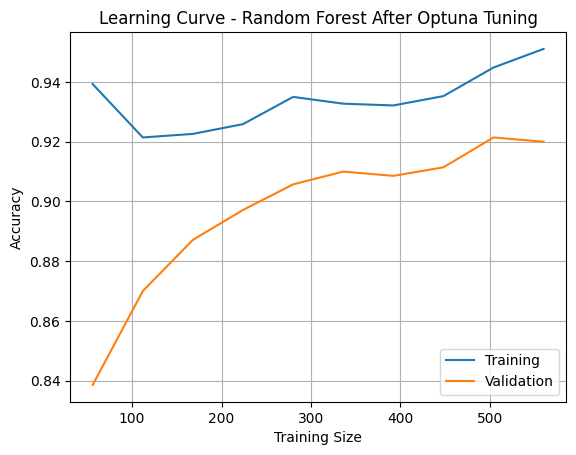

In [26]:
best_params = study_rf.best_trial.params
best_params['random_state'] = 42
best_params['oob_score'] = True
best_params['bootstrap'] = True

best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_sm, y_train_sm)

# Evaluation
evaluate_model("Random Forest After Optuna Tuning", best_rf_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)
plot_model("Random Forest After Optuna Tuning", best_rf_model)

# **2. XGBoost**


=== Evaluation XGBoost Before Tuning ===
Train Accuracy: 0.9704433497536946
Validation Accuracy: 0.945273631840796
Test Accuracy: 0.8888888888888888

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.88      0.93      0.91        57

    accuracy                           0.89        99
   macro avg       0.89      0.88      0.89        99
weighted avg       0.89      0.89      0.89        99

Confusion Matrix:
 [[35  7]
 [ 4 53]]


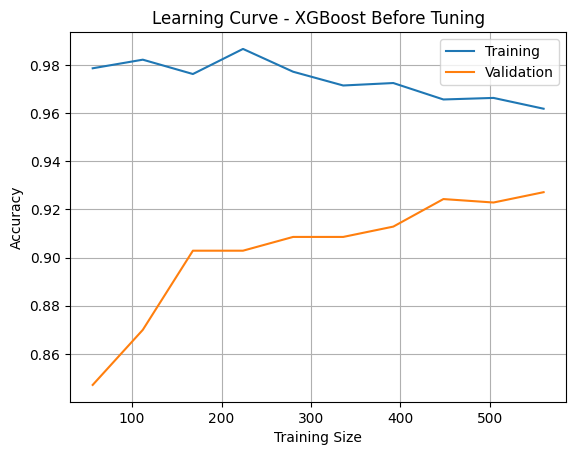

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(
    n_estimators=100, # 100 150
    max_depth=3, # 3 2
    learning_rate=0.1, # 0.1 0.05
    subsample=0.8, # 0.8 0.7
    colsample_bytree=0.5, # 0.5 0.3
    reg_alpha=0.1, # 0.1 0.5
    reg_lambda=1.0, # 1.0 1.5
    gamma=0.1,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_sm, y_train_sm)

# EVALUATION 1
evaluate_model("XGBoost Before Tuning", xgb_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)

# EVALUATION 2
plot_model("XGBoost Before Tuning", xgb_model)

# **DATA TUNING: XGBOOST**

In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'random_state': 42,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train_sm, y_train_sm, cv=cv, scoring='accuracy', n_jobs=-1).mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print("Best Parameters (XGBoost - Optuna):", study_xgb.best_trial.params)
print("Best CV Score:", study_xgb.best_trial.value)

[I 2025-08-04 18:03:46,416] A new study created in memory with name: no-name-a8e1395f-4dfc-4e96-9356-076a9b057269
Best trial: 0. Best value: 0.933508:   7%|▋         | 2/30 [00:00<00:04,  6.70it/s]

[I 2025-08-04 18:03:46,623] Trial 0 finished with value: 0.9335075361660227 and parameters: {'n_estimators': 186, 'max_depth': 6, 'learning_rate': 0.15271105990265602, 'subsample': 0.9038980797161407, 'colsample_bytree': 0.3164488140469089, 'reg_alpha': 0.7632664275660669, 'reg_lambda': 1.0403753768971697, 'gamma': 0.3049974791096625}. Best is trial 0 with value: 0.9335075361660227.
[I 2025-08-04 18:03:46,732] Trial 1 finished with value: 0.9113610543058396 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.020840087482129243, 'subsample': 0.6035314409666673, 'colsample_bytree': 0.901633649421256, 'reg_alpha': 0.05187367145488275, 'reg_lambda': 0.5019959115988302, 'gamma': 0.20801460386678056}. Best is trial 0 with value: 0.9335075361660227.


Best trial: 4. Best value: 0.945808:  17%|█▋        | 5/30 [00:00<00:02,  9.51it/s]

[I 2025-08-04 18:03:46,842] Trial 2 finished with value: 0.9372036658335228 and parameters: {'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.13173578051445886, 'subsample': 0.680312398168887, 'colsample_bytree': 0.6085744445741321, 'reg_alpha': 0.5507237049056009, 'reg_lambda': 1.5694242329408477, 'gamma': 0.08997327260451515}. Best is trial 2 with value: 0.9372036658335228.
[I 2025-08-04 18:03:46,903] Trial 3 finished with value: 0.919965159433462 and parameters: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.016676542766760446, 'subsample': 0.9942077430032835, 'colsample_bytree': 0.6886167656324721, 'reg_alpha': 0.8883987044252756, 'reg_lambda': 0.8146938772477625, 'gamma': 0.06381807553387331}. Best is trial 2 with value: 0.9372036658335228.
[I 2025-08-04 18:03:47,012] Trial 4 finished with value: 0.9458077709611452 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.02639939810129599, 'subsample': 0.6836548537694676, 'colsample_bytree': 0.5850

Best trial: 6. Best value: 0.954435:  23%|██▎       | 7/30 [00:00<00:02, 10.05it/s]

[I 2025-08-04 18:03:47,088] Trial 5 finished with value: 0.9236461410285541 and parameters: {'n_estimators': 160, 'max_depth': 9, 'learning_rate': 0.010185490654002574, 'subsample': 0.9500583831982088, 'colsample_bytree': 0.30214169725985157, 'reg_alpha': 0.962367668647809, 'reg_lambda': 1.3400469518322897, 'gamma': 0.06821767099918064}. Best is trial 4 with value: 0.9458077709611452.
[I 2025-08-04 18:03:47,197] Trial 6 finished with value: 0.9544345981973794 and parameters: {'n_estimators': 298, 'max_depth': 8, 'learning_rate': 0.022786955071151457, 'subsample': 0.8571558586843107, 'colsample_bytree': 0.8260472436421789, 'reg_alpha': 0.06006814334846877, 'reg_lambda': 0.8183965644432492, 'gamma': 0.4142275012102598}. Best is trial 6 with value: 0.9544345981973794.
[I 2025-08-04 18:03:47,259] Trial 7 finished with value: 0.9322653942285845 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.15031873767285087, 'subsample': 0.6413568841080345, 'colsample_bytree': 0.9

Best trial: 6. Best value: 0.954435:  30%|███       | 9/30 [00:01<00:01, 11.73it/s]

[I 2025-08-04 18:03:47,321] Trial 8 finished with value: 0.8965462394910247 and parameters: {'n_estimators': 265, 'max_depth': 2, 'learning_rate': 0.011286689281940413, 'subsample': 0.8302864366169374, 'colsample_bytree': 0.3545979458022739, 'reg_alpha': 0.4212515998422094, 'reg_lambda': 0.7224909331430587, 'gamma': 0.31614015753133057}. Best is trial 6 with value: 0.9544345981973794.
[I 2025-08-04 18:03:47,419] Trial 9 finished with value: 0.9372112398697265 and parameters: {'n_estimators': 249, 'max_depth': 9, 'learning_rate': 0.017496337213093256, 'subsample': 0.6240497849623763, 'colsample_bytree': 0.4825863746471083, 'reg_alpha': 0.7022022018442927, 'reg_lambda': 0.1599981071110399, 'gamma': 0.2997624725906533}. Best is trial 6 with value: 0.9544345981973794.


Best trial: 6. Best value: 0.954435:  37%|███▋      | 11/30 [00:01<00:01, 10.90it/s]

[I 2025-08-04 18:03:47,528] Trial 10 finished with value: 0.9482541846550028 and parameters: {'n_estimators': 298, 'max_depth': 10, 'learning_rate': 0.05182486932036971, 'subsample': 0.7878790528884213, 'colsample_bytree': 0.769689001947679, 'reg_alpha': 0.013310063545601297, 'reg_lambda': 1.7889194528050671, 'gamma': 0.4630297523404724}. Best is trial 6 with value: 0.9544345981973794.
[I 2025-08-04 18:03:47,637] Trial 11 finished with value: 0.9470196167537681 and parameters: {'n_estimators': 292, 'max_depth': 10, 'learning_rate': 0.05664655735411508, 'subsample': 0.8012575353586959, 'colsample_bytree': 0.7753736178229858, 'reg_alpha': 0.043574979600681664, 'reg_lambda': 1.9718248390006299, 'gamma': 0.4721430731609562}. Best is trial 6 with value: 0.9544345981973794.


Best trial: 6. Best value: 0.954435:  50%|█████     | 15/30 [00:01<00:01, 11.16it/s]

[I 2025-08-04 18:03:47,715] Trial 12 finished with value: 0.9532000302961448 and parameters: {'n_estimators': 102, 'max_depth': 8, 'learning_rate': 0.049863124826589555, 'subsample': 0.861615337719208, 'colsample_bytree': 0.8251590013264511, 'reg_alpha': 0.22355663322344985, 'reg_lambda': 1.1838812892829407, 'gamma': 0.4971813980071291}. Best is trial 6 with value: 0.9544345981973794.
[I 2025-08-04 18:03:47,792] Trial 13 finished with value: 0.9445883511323183 and parameters: {'n_estimators': 106, 'max_depth': 7, 'learning_rate': 0.034981548675339307, 'subsample': 0.871898837336999, 'colsample_bytree': 0.9829752383962846, 'reg_alpha': 0.21077162314772907, 'reg_lambda': 1.2190952980076646, 'gamma': 0.4969502244720036}. Best is trial 6 with value: 0.9544345981973794.
[I 2025-08-04 18:03:47,884] Trial 14 finished with value: 0.9445732030599107 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.09978174070976917, 'subsample': 0.7548670874697913, 'colsample_bytree': 0.

Best trial: 6. Best value: 0.954435:  57%|█████▋    | 17/30 [00:01<00:01, 11.03it/s]

[I 2025-08-04 18:03:47,962] Trial 15 finished with value: 0.9470347648261758 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.0753276809559111, 'subsample': 0.8740380611830332, 'colsample_bytree': 0.7067579901295151, 'reg_alpha': 0.1691378841005812, 'reg_lambda': 1.547566971445063, 'gamma': 0.4066734061430703}. Best is trial 6 with value: 0.9544345981973794.
[I 2025-08-04 18:03:48,070] Trial 16 finished with value: 0.9482541846550028 and parameters: {'n_estimators': 220, 'max_depth': 8, 'learning_rate': 0.036734868893203015, 'subsample': 0.7389104407674735, 'colsample_bytree': 0.834702939842636, 'reg_alpha': 0.355647642929777, 'reg_lambda': 0.7054415595855852, 'gamma': 0.17792211008236186}. Best is trial 6 with value: 0.9544345981973794.


Best trial: 6. Best value: 0.954435:  63%|██████▎   | 19/30 [00:01<00:01, 10.96it/s]

[I 2025-08-04 18:03:48,162] Trial 17 finished with value: 0.9482693327274104 and parameters: {'n_estimators': 170, 'max_depth': 7, 'learning_rate': 0.03050704184812535, 'subsample': 0.9285026595639823, 'colsample_bytree': 0.9999552657370812, 'reg_alpha': 0.5685537202588734, 'reg_lambda': 1.3575527280265898, 'gamma': 0.42850251794567695}. Best is trial 6 with value: 0.9544345981973794.
[I 2025-08-04 18:03:48,253] Trial 18 finished with value: 0.9495039006286451 and parameters: {'n_estimators': 122, 'max_depth': 8, 'learning_rate': 0.07269002172635278, 'subsample': 0.8524695727787905, 'colsample_bytree': 0.530371909257146, 'reg_alpha': 0.11500905233095018, 'reg_lambda': 0.976553250316968, 'gamma': 0.3583639210763345}. Best is trial 6 with value: 0.9544345981973794.


Best trial: 20. Best value: 0.955654:  70%|███████   | 21/30 [00:02<00:00, 10.42it/s]

[I 2025-08-04 18:03:48,360] Trial 19 finished with value: 0.9544421722335832 and parameters: {'n_estimators': 269, 'max_depth': 6, 'learning_rate': 0.0434846570171586, 'subsample': 0.9799674118887463, 'colsample_bytree': 0.858359246590727, 'reg_alpha': 0.3112468486296652, 'reg_lambda': 0.40814054575080794, 'gamma': 0.44529669047541365}. Best is trial 19 with value: 0.9544421722335832.
[I 2025-08-04 18:03:48,469] Trial 20 finished with value: 0.9556540180262061 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.025596636965753004, 'subsample': 0.9845274258316914, 'colsample_bytree': 0.8956038995147338, 'reg_alpha': 0.3231538328209407, 'reg_lambda': 0.01913323514598142, 'gamma': 0.25432514791286753}. Best is trial 20 with value: 0.9556540180262061.


Best trial: 20. Best value: 0.955654:  77%|███████▋  | 23/30 [00:02<00:00,  9.57it/s]

[I 2025-08-04 18:03:48,594] Trial 21 finished with value: 0.9544270241611755 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.023675005951876733, 'subsample': 0.9950153310382263, 'colsample_bytree': 0.9296385169807393, 'reg_alpha': 0.32304647670851905, 'reg_lambda': 0.05879718589820065, 'gamma': 0.1384074943103297}. Best is trial 20 with value: 0.9556540180262061.
[I 2025-08-04 18:03:48,716] Trial 22 finished with value: 0.9519578883587062 and parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.01467259861313297, 'subsample': 0.950585305827559, 'colsample_bytree': 0.8795968954603794, 'reg_alpha': 0.44612454414718083, 'reg_lambda': 0.3869158551147698, 'gamma': 0.23389427764514778}. Best is trial 20 with value: 0.9556540180262061.


Best trial: 20. Best value: 0.955654:  83%|████████▎ | 25/30 [00:02<00:00,  9.48it/s]

[I 2025-08-04 18:03:48,824] Trial 23 finished with value: 0.9544043020525639 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.03949647869757719, 'subsample': 0.9210655493424599, 'colsample_bytree': 0.758059245236402, 'reg_alpha': 0.290877244650708, 'reg_lambda': 0.04289115630676403, 'gamma': 0.35888912562137043}. Best is trial 20 with value: 0.9556540180262061.
[I 2025-08-04 18:03:48,932] Trial 24 finished with value: 0.9544421722335834 and parameters: {'n_estimators': 228, 'max_depth': 6, 'learning_rate': 0.027982633546835375, 'subsample': 0.9667274069165612, 'colsample_bytree': 0.7247841294644719, 'reg_alpha': 0.11811137211206016, 'reg_lambda': 0.29518408719219313, 'gamma': 0.44674695384740265}. Best is trial 20 with value: 0.9556540180262061.


Best trial: 26. Best value: 0.958108:  90%|█████████ | 27/30 [00:02<00:00,  9.91it/s]

[I 2025-08-04 18:03:49,023] Trial 25 finished with value: 0.9544270241611755 and parameters: {'n_estimators': 220, 'max_depth': 4, 'learning_rate': 0.030477250130305826, 'subsample': 0.9576333834918678, 'colsample_bytree': 0.7052539164384518, 'reg_alpha': 0.12660970433934374, 'reg_lambda': 0.29042664885687347, 'gamma': 0.019844865882566565}. Best is trial 20 with value: 0.9556540180262061.
[I 2025-08-04 18:03:49,117] Trial 26 finished with value: 0.9581080057562674 and parameters: {'n_estimators': 235, 'max_depth': 6, 'learning_rate': 0.06457518276069818, 'subsample': 0.998982353947451, 'colsample_bytree': 0.6445921629629068, 'reg_alpha': 0.3600117110056858, 'reg_lambda': 0.5356730359731774, 'gamma': 0.4451335207903719}. Best is trial 26 with value: 0.9581080057562674.


[I 2025-08-04 18:03:49,210] Trial 27 finished with value: 0.9482693327274104 and parameters: {'n_estimators': 234, 'max_depth': 4, 'learning_rate': 0.0691490357890361, 'subsample': 0.9002728306773209, 'colsample_bytree': 0.6251217421561418, 'reg_alpha': 0.6281461729774014, 'reg_lambda': 0.6100315632134649, 'gamma': 0.27305788322290553}. Best is trial 26 with value: 0.9581080057562674.
[I 2025-08-04 18:03:49,304] Trial 28 finished with value: 0.9470574869347876 and parameters: {'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.09376523510481422, 'subsample': 0.9701405391493186, 'colsample_bytree': 0.4353155351008708, 'reg_alpha': 0.5152622785131384, 'reg_lambda': 0.0005133355219060672, 'gamma': 0.3654866855882222}. Best is trial 26 with value: 0.9581080057562674.


Best trial: 26. Best value: 0.958108: 100%|██████████| 30/30 [00:02<00:00, 10.07it/s]

[I 2025-08-04 18:03:49,395] Trial 29 finished with value: 0.9507308944936756 and parameters: {'n_estimators': 214, 'max_depth': 6, 'learning_rate': 0.061460606334634675, 'subsample': 0.9051567842184663, 'colsample_bytree': 0.568270605408058, 'reg_alpha': 0.36327078144531594, 'reg_lambda': 0.1994067303193643, 'gamma': 0.3270560816981408}. Best is trial 26 with value: 0.9581080057562674.
Best Parameters (XGBoost - Optuna): {'n_estimators': 235, 'max_depth': 6, 'learning_rate': 0.06457518276069818, 'subsample': 0.998982353947451, 'colsample_bytree': 0.6445921629629068, 'reg_alpha': 0.3600117110056858, 'reg_lambda': 0.5356730359731774, 'gamma': 0.4451335207903719}
Best CV Score: 0.9581080057562674


c:\Users\fance\.conda\envs\heartastic\lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\fance\.conda\envs\heartastic\lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Evaluation XGBoost After Optuna Tuning ===
Train Accuracy: 0.9901477832512315
Validation Accuracy: 0.945273631840796
Test Accuracy: 0.898989898989899

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.91      0.91      0.91        57

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.90      0.90      0.90        99

Confusion Matrix:
 [[37  5]
 [ 5 52]]


c:\Users\fance\.conda\envs\heartastic\lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\fance\.conda\envs\heartastic\lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\fance\.conda\envs\heartastic\lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\fance\.conda\envs\heartastic\lib\site-packages\xgboost\training.py:183: UserWarning: [18:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

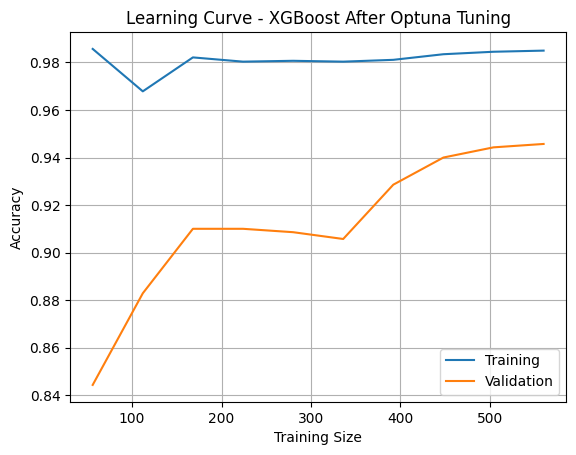

In [29]:
best_params_xgb = study_xgb.best_trial.params
best_params_xgb['random_state'] = 42
best_params_xgb['eval_metric'] = 'logloss'
best_params_xgb['use_label_encoder'] = False

best_xgb_model = XGBClassifier(**best_params_xgb)
best_xgb_model.fit(X_train_sm, y_train_sm)

# Evaluation
evaluate_model("XGBoost After Optuna Tuning", best_xgb_model, X_train_sm, X_val, X_test, y_train_sm, y_val, y_test)
plot_model("XGBoost After Optuna Tuning", best_xgb_model)

# **E. DEPLOYMENT**

In [30]:
# SAVE TO FILE
import joblib

joblib.dump(best_xgb_model, "xgb_heart_model.pkl")

# from google.colab import files
# files.download("xgb_heart_model.pkl")

['xgb_heart_model.pkl']